<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/Langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 884.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.2 MB/s eta 0:00:00


In [2]:
import langgraph

In [3]:
# pydantic is used to validate the information your agent parses

In [4]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY']=userdata.get('groq_api_key')

In [5]:
EMAILS = [
    # Email 0
    """
    Date: October 15, 2024
    From: Occupational Safety and Health Administration (OSHA)
    To: Blue Ridge Construction, project 111232345 - Downtown Office
    Complex Location: Dallas, TX

    During a recent inspection of your construction site at 123 Main
    Street,
    the following safety violations were identified:

    Lack of fall protection: Workers on scaffolding above 10 feet
    were without required harnesses or other fall protection
    equipment. Unsafe scaffolding setup: Several scaffolding
    structures were noted as
    lacking secure base plates and bracing, creating potential
    collapse risks.
    Inadequate personal protective equipment (PPE): Multiple
    workers were
    found without proper PPE, including hard hats and safety
    glasses.
    Required Corrective Actions:

    Install guardrails and fall arrest systems on all scaffolding
    over 10 feet. Conduct an inspection of all scaffolding
    structures and reinforce unstable sections. Ensure all
    workers on-site are provided
    with necessary PPE and conduct safety training on proper
    usage.
    Deadline for Compliance: All violations must be rectified
    by November 10, 2024. Failure to comply may result in fines
    of up to
    $25,000 per violation.

    Contact: For questions or to confirm compliance, please reach
    out to the
    OSHA regional office at (555) 123-4567 or email
    compliance.osha@osha.gov.
    """,
    # Email 1
    """
    From: debby@stack.com
    Hey Betsy,
    Here's your invoice for $1000 for the cookies you ordered.
    """,
    # Email 2
    """
    From: tdavid@companyxyz.com
    Hi Paul,
    We have an issue with the HVAC system your team installed in
    apartment 1235. We'd like to request maintenance or a refund.
    Thanks,
    Terrance
    """,
    # Email 3
    """
    Date: January 10, 2025
    From: City of Los Angeles Building and Safety Department
    To: West Coast Development, project 345678123 - Sunset Luxury
    Condominiums
    Location: Los Angeles, CA
    Following an inspection of your site at 456 Sunset Boulevard, we have
    identified the following building code violations:
    Electrical Wiring: Exposed wiring was found in the underground parking
    garage, posing a safety hazard. Fire Safety: Insufficient fire
    extinguishers were available across multiple floors of the structure
    under construction.
    Structural Integrity: The temporary support beams in the eastern wing
    do not meet the load-bearing standards specified in local building
    codes.
    Required Corrective Actions:
    Replace or properly secure exposed wiring to meet electrical safety
    standards. Install additional fire extinguishers in compliance with
    fire code requirements. Reinforce or replace temporary support beams
    to ensure structural stability. Deadline for Compliance: Violations
    must be addressed no later than February 5,
    2025. Failure to comply may result in
    a stop-work order and additional fines.
    Contact: For questions or to schedule a re-inspection, please contact
    the Building and Safety Department at
    (555) 456-7890 or email inspections@lacity.gov.
    """,
]

LangGraph is all about implementing LLM applications as directed graphs.

You can think of a directed graph as a sequence of instructions composed of nodes and edges, that tell you how to complete a task. In LangGraph, nodes represent actions that your graph can take, such as calling a function, and edges tell you which node to go to next.

Your job is to build a tool that can read these emails, extract critical information from them, and notify the correct internal team who will take action. The first step you’ll take to accomplish this is to build a LangChain chain that uses an LLM to extract structured fields from a regulatory notice email. You start by defining a Pydantic BaseModel that describes all the fields you want to extract from the email:

In [6]:
!pip install langchain langchain_groq langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.1/417.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.45
    Uninstalling langchain-core-0.3.45:
      Successfully uninstalled langchain-core-0.3.45


In [7]:
from datetime import datetime, date
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field, computed_field

class NoticeEmailExtract(BaseModel):
    date_of_notice_str: str | None = Field(
        default=None,
        exclude=True,
        repr=False,
        description="""The date of the notice (if any) reformatted
        to match YYYY-mm-dd""",
    )
    entity_name: str | None = Field(
        default=None,
        description="""The name of the entity sending the notice (if present
        in the message)""",
    )
    entity_phone: str | None = Field(
        default=None,
        description="""The phone number of the entity sending the notice
        (if present in the message)""",
    )
    entity_email: str | None = Field(
        default=None,
        description="""The email of the entity sending the notice
        (if present in the message)""",
    )
    project_id: int | None = Field(
        default=None,
        description="""The project ID (if present in the message) -
        must be an integer""",
    )
    site_location: str | None = Field(
        default=None,
        description="""The site location of the project (if present
        in the message). Use the full address if possible.""",
    )
    violation_type: str | None = Field(
        default=None,
        description="""The type of violation (if present in the
        message)""",
    )
    required_changes: str | None = Field(
        default=None,
        description="""The required changes specified by the entity
        (if present in the message)""",
    )
    compliance_deadline_str: str | None = Field(
        default=None,
        exclude=True,
        repr=False,
        description="""The date that the company must comply (if any)
        reformatted to match YYYY-mm-dd""",
    )
    max_potential_fine: float | None = Field(
        default=None,
        description="""The maximum potential fine
        (if any)""",
    )

    @staticmethod
    def _convert_string_to_date(date_str: str | None) -> date | None:
        try:
            return datetime.strptime(date_str, "%Y-%m-%d").date()
        except Exception as e:
            print(e)
            return None

    @computed_field
    @property
    def date_of_notice(self) -> date | None:
        return self._convert_string_to_date(self.date_of_notice_str)

    @computed_field
    @property
    def compliance_deadline(self) -> date | None:
        return self._convert_string_to_date(self.compliance_deadline_str)

In [8]:
info_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Parse the date of notice, sending entity name, sending entity
            phone, sending entity email, project id, site location,
            violation type, required changes, compliance deadline, and
            maximum potential fine from the message. If any of the fields
            aren't present, don't populate them. Try to cast dates into
            the YYYY-mm-dd format. Don't populate fields if they're not
            present in the message.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

notice_parser_model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

NOTICE_PARSER_CHAIN = (
    info_parse_prompt
    | notice_parser_model.with_structured_output(NoticeEmailExtract)
)

In [10]:
info_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Parse the date of notice, sending entity name, sending entity
            phone, sending entity email, project id, site location,
            violation type, required changes, compliance deadline, and
            maximum potential fine from the message. If any of the fields
            aren't present, don't populate them. Try to cast dates into
            the YYYY-mm-dd format. Don't populate fields if they're not
            present in the message.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

notice_parser_model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

NOTICE_PARSER_CHAIN = (
    info_parse_prompt
    | notice_parser_model.with_structured_output(NoticeEmailExtract)
)

In [11]:
NOTICE_PARSER_CHAIN.invoke({"message": EMAILS[0]})

NoticeEmailExtract(entity_name='Occupational Safety and Health Administration (OSHA)', entity_phone='(555) 123-4567', entity_email='compliance.osha@osha.gov', project_id=111232345, site_location='123 Main Street, Dallas, TX', violation_type='Lack of fall protection, Unsafe scaffolding setup, Inadequate personal protective equipment (PPE)', required_changes='Install guardrails and fall arrest systems on all scaffolding over 10 feet. Conduct an inspection of all scaffolding structures and reinforce unstable sections. Ensure all workers on-site are provided with necessary PPE and conduct safety training on proper usage.', max_potential_fine=25000.0, date_of_notice=datetime.date(2024, 10, 15), compliance_deadline=datetime.date(2024, 11, 10))

In [13]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class EscalationCheck(BaseModel):
  needs_escalation: bool=Field(
      description="""Whether the notice requires escalation
        according to specified criteria"""
  )

escalation_prompt=ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Determine whether the following notice received
            from a regulatory body requires immediate escalation.
            Immediate escalation is required when {escalation_criteria}.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

escalation_check_model=ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

ESCALATION_CHECK_CHAIN=(
    escalation_prompt
    | escalation_check_model.with_structured_output(EscalationCheck)
)

In [14]:
escalation_criteria = """There is currently water damage
... or potential water damage reported"""

In [17]:
message = """Several cracks in the foundation have been identified along with water leak"""

In [18]:
ESCALATION_CHECK_CHAIN.invoke(
     {"message": message, "escalation_criteria": escalation_criteria}
)

EscalationCheck(needs_escalation=True)

In [19]:
message="The wheel chair ramps are too steep"

ESCALATION_CHECK_CHAIN.invoke(
     {"message": message, "escalation_criteria": escalation_criteria}
)

EscalationCheck(needs_escalation=False)

Now that you’ve built the notice parsing and escalation check chains, you need to orchestrate them and add additional functionality that your company requires to process notice emails. To do this, you’ll use LangGraph’s StateGraph to create a graph that builds upon NOTICE_PARSER_CHAIN and ESCALATION_CHECK_CHAIN. Before getting started, you’ll want to initialize a logger that you’ll use throughout this tutorial:

In [20]:
import logging

logging.getLogger("httpx").setLevel(logging.WARNING)
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
LOGGER = logging.getLogger(__name__)

In [22]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph
from pydantic import EmailStr

In [23]:
class GraphState(TypedDict):
    notice_message: str
    notice_email_extract: NoticeEmailExtract | None
    escalation_text_criteria: str
    escalation_dollar_criteria: float
    requires_escalation: bool
    escalation_emails: list[EmailStr] | None
    follow_ups: dict[str, bool] | None
    current_follow_up: str | None

workflow = StateGraph(GraphState)

In [24]:
def parse_notice_message_node(state:GraphState)->GraphState:
    """Use the notice parser chain to extract fields from the notice"""
    notice_email_extract = NOTICE_PARSER_CHAIN.invoke(
        {"message": state["notice_message"]}
    )
    state["notice_email_extract"] = notice_email_extract
    return state

In [25]:
def check_escalation_status_node(state: GraphState) -> GraphState:
    """Determine whether a notice needs escalation"""
    text_check = ESCALATION_CHECK_CHAIN.invoke(
        {
            "escalation_criteria": state["escalation_text_criteria"],
            "message": state["notice_message"],
        }
    ).needs_escalation

    if (
        text_check
        or state["notice_email_extract"].max_potential_fine
        >= state["escalation_dollar_criteria"]
    ):
        state["requires_escalation"] = True
    else:
        state["requires_escalation"] = False

    return state

workflow.add_node("parse_notice_message", parse_notice_message_node)
workflow.add_node("check_escalation_status", check_escalation_status_node)

 In general, all node functions accept the graph state, perform some action, update the graph state, and return the graph state.

The next thing you need to do is add edges to your graph. Edges control the flow of data between nodes in your graph

In [26]:
# ...

workflow.add_edge(START, "parse_notice_message")
workflow.add_edge("parse_notice_message", "check_escalation_status")
workflow.add_edge("check_escalation_status", END)

NOTICE_EXTRACTION_GRAPH = workflow.compile()

In [29]:
!pip install pydantic[email]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 8.3 MB/s eta 0:00:00


In [30]:
image_data = NOTICE_EXTRACTION_GRAPH.get_graph().draw_mermaid_png()
with open("notice_extraction_graph.png", mode="wb") as f:
  f.write(image_data)

In [31]:
initial_state = {
    "notice_message": EMAILS[0],
    "notice_email_extract": None,
    "escalation_text_criteria": """There's a risk of fire or
    water damage at the site""",
    "escalation_dollar_criteria": 100_000,
    "requires_escalation": False,
    "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

In [32]:
final_state=NOTICE_EXTRACTION_GRAPH.invoke(initial_state)

In [33]:
final_state["notice_email_extract"]

NoticeEmailExtract(entity_name='Occupational Safety and Health Administration (OSHA)', entity_phone='(555) 123-4567', entity_email='compliance.osha@osha.gov', project_id=111232345, site_location='123 Main Street, Dallas, TX', violation_type='Lack of fall protection, Unsafe scaffolding setup, Inadequate personal protective equipment (PPE)', required_changes='Install guardrails and fall arrest systems on all scaffolding over 10 feet. Conduct an inspection of all scaffolding structures and reinforce unstable sections. Ensure all workers on-site are provided with necessary PPE and conduct safety training on proper usage.', max_potential_fine=25000.0, date_of_notice=datetime.date(2024, 10, 15), compliance_deadline=datetime.date(2024, 11, 10))

In [34]:
final_state["requires_escalation"]

False

So far, you’ve built a graph with a couple of nodes and edges between them that can’t do much more than a chain. In this section, you’ll learn about conditional edges, which you can use to move beyond chain-like structures to create intricate, conditional, and even cyclic workflows.

In [36]:
import random
import time
from pydantic import EmailStr

def send_escalation_email(
    notice_email_extract: NoticeEmailExtract,
    escalation_emails: list[EmailStr]
) -> None:
    """Simulate sending escalation emails"""
    for email in escalation_emails:
        time.sleep(1)

def create_legal_ticket(
    current_follow_ups: dict[str, bool] | None,
    notice_email_extract: NoticeEmailExtract,
) -> str | None:
    """Simulate creating a legal ticket using your company's API."""
    time.sleep(2)

    follow_ups = [
        None,
        """Does this message mention the states of Texas,
        Georgia, or New Jersey?""",
        """Did this notice involve an issue with FakeAirCo's
        HVAC system?""",
    ]

    if current_follow_ups:
        follow_ups = [
            f for f in follow_ups if f not in current_follow_ups.keys()
        ]
    follow_up = random.choice(follow_ups)
    if not follow_up:
        return follow_up
    return follow_up

In [37]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph
from pydantic import EmailStr


def send_escalation_email_node(state: GraphState) -> GraphState:
    """Send an escalation email"""
    send_escalation_email(
        notice_email_extract=state["notice_email_extract"],
        escalation_emails=state["escalation_emails"],
    )
    return state

def create_legal_ticket_node(state: GraphState) -> GraphState:
    """Node to create a legal ticket"""
    follow_up = create_legal_ticket(
        current_follow_ups=state.get("follow_ups"),
        notice_email_extract=state["notice_email_extract"],
    )
    state["current_follow_up"] = follow_up
    return state

In [41]:
# ...

def route_escalation_status_edge(state: GraphState) -> str:
    """Determine whether to send an escalation email or
    create a legal ticket"""
    if state["requires_escalation"]:
        return "send_escalation_email"
    return "create_legal_ticket"


workflow.add_node("send_escalation_email", send_escalation_email_node)
workflow.add_node("create_legal_ticket", create_legal_ticket_node)

workflow.add_edge(START, "parse_notice_message")
workflow.add_edge("parse_notice_message", "check_escalation_status")
workflow.add_conditional_edges(
    "check_escalation_status",
    route_escalation_status_edge,
    {
        "send_escalation_email": "send_escalation_email",
        "create_legal_ticket": "create_legal_ticket",
    },
)
workflow.add_edge("send_escalation_email", "create_legal_ticket")
workflow.add_edge("create_legal_ticket", END)

NOTICE_EXTRACTION_GRAPH = workflow.compile()

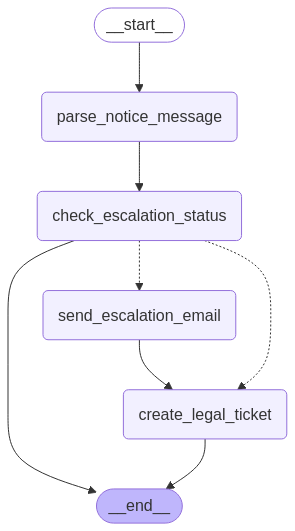

In [42]:
NOTICE_EXTRACTION_GRAPH

In [43]:
initial_state_no_escalation = {
    "notice_message": EMAILS[0],
    "notice_email_extract": None,
    "escalation_text_criteria": """There's a risk of water
     damage at the site""",
    "escalation_dollar_criteria": 100_000,
    "requires_escalation": False,
    "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

initial_state_escalation = {
    "notice_message": EMAILS[0],
    "notice_email_extract": None,
    "escalation_text_criteria": """Workers explicitly violating
     safety protocols""",
    "escalation_dollar_criteria": 100_000,
    "requires_escalation": False,
    "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

In [46]:
no_esc_result = NOTICE_EXTRACTION_GRAPH.invoke(initial_state_no_escalation)

In [47]:
no_esc_result["requires_escalation"]

False

In [48]:
esc_result = NOTICE_EXTRACTION_GRAPH.invoke(initial_state_escalation)

In [49]:
esc_result["requires_escalation"]

True

In [50]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class BinaryAnswer(BaseModel):
    is_true: bool = Field(
        description="""Whether the answer to the question is yes or no.
        True if yes otherwise False."""
    )

binary_question_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Answer this question as True for "yes" and False for "no".
            No other answers are allowed:

            {question}
            """,
        )
    ]
)

binary_question_model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

BINARY_QUESTION_CHAIN = (
    binary_question_prompt
    | binary_question_model.with_structured_output(BinaryAnswer)
)

In [51]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph
from pydantic import EmailStr

def answer_follow_up_question_node(state: GraphState) -> GraphState:
    """Answer follow-up questions about the notice using
    BINARY_QUESTION_CHAIN"""
    if state["current_follow_up"]:
        question = state["current_follow_up"] + " " + state["notice_message"]
        answer = BINARY_QUESTION_CHAIN.invoke({"question": question})
        if state.get("follow_ups"):
            state["follow_ups"][state["current_follow_up"]] = answer
        else:
            state["follow_ups"] = {state["current_follow_up"]: answer}
    return state

In [52]:
# ...

def route_follow_up_edge(state: GraphState) -> str:
    """Determine whether a follow-up question is required"""
    if state.get("current_follow_up"):
        return "answer_follow_up_question"
    return END

# ...

In [59]:
# ...

workflow.add_edge(START, "parse_notice_message")
workflow.add_edge("parse_notice_message", "check_escalation_status")
workflow.add_conditional_edges(
    "create_legal_ticket",
    route_follow_up_edge,
    {
        "answer_follow_up_question": "answer_follow_up_question",
        END: END,
    },
)

workflow.add_edge("send_escalation_email", "create_legal_ticket")
workflow.add_edge("answer_follow_up_question", "create_legal_ticket")

NOTICE_EXTRACTION_GRAPH = workflow.compile()

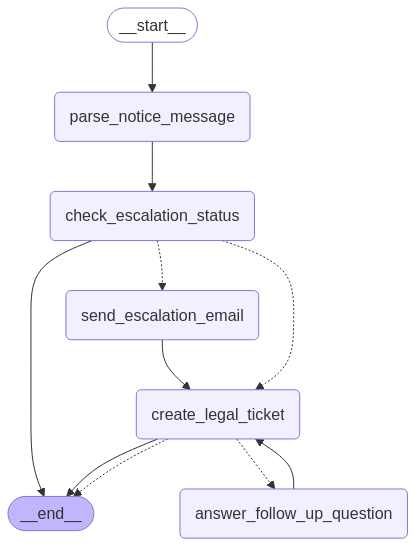

In [60]:
NOTICE_EXTRACTION_GRAPH

In [61]:
results = NOTICE_EXTRACTION_GRAPH.invoke(initial_state_escalation)

In [62]:
results["follow_ups"]

{"Did this notice involve an issue with FakeAirCo's\n        HVAC system?": BinaryAnswer(is_true=False)}